In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import itertools
import collections
import queue
import scipy.io as spio

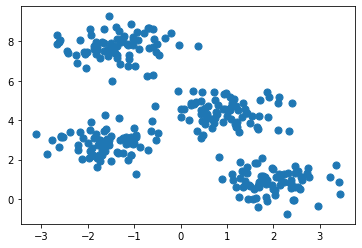

In [6]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)

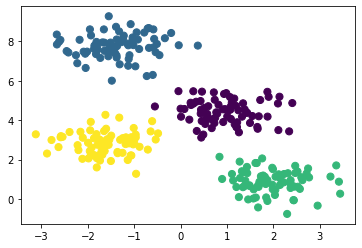

In [91]:
from sklearn.metrics import pairwise_distances_argmin

def aLabel(X, centers):
    dist = np.array([[np.sqrt(np.square(x[0]-y[0]) + np.square(x[1]-y[1])) for x in centers] for y in X])
    
    mins = np.array([m.min() for m in dist]).T

    labs = np.array([np.where(mins[i] == dist[i]) for i in range(len(mins))]).T

    return labs[0][0]


def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = aLabel(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

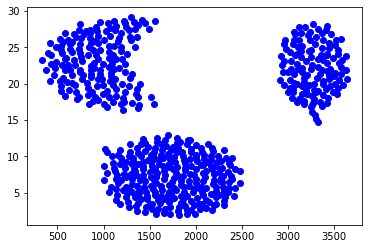

In [92]:
with open('cluster.dat') as f:
    lines = f.readlines()
    x = [float(line.split()[0]) for line in lines]
    y = [float(line.split()[1]) for line in lines]
plt.plot(x, y,'ob')
plt.show()

In [93]:

xy =[]
with open('cluster.dat') as f:
    lines = f.readlines()
    for line in lines:
        aux = [float(line.split()[0]) * 0.01,float(line.split()[1])]
        xy.append(aux)

    
Points = np.array(xy)
print(Points)
Points

[[15.55 28.65]
 [14.9  27.55]
 [14.45 28.35]
 ...
 [35.25 26.  ]
 [35.7  26.15]
 [34.4  25.6 ]]


array([[15.55, 28.65],
       [14.9 , 27.55],
       [14.45, 28.35],
       ...,
       [35.25, 26.  ],
       [35.7 , 26.15],
       [34.4 , 25.6 ]])

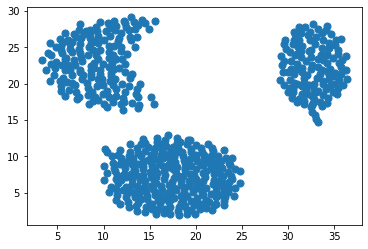

In [94]:
plt.scatter(Points[:, 0], Points[:, 1], s=50)

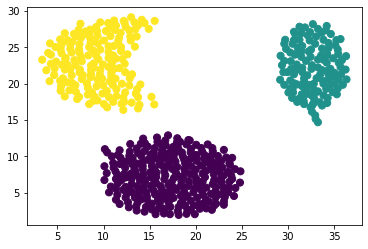

In [95]:
centers, labels = find_clusters(Points, 3)
plt.scatter(Points[:, 0], Points[:, 1], c=labels,
            s=50, cmap='viridis')

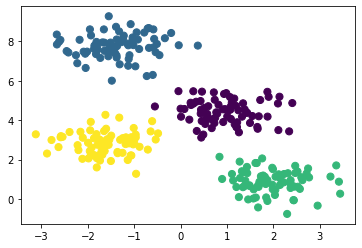

In [96]:

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')

In [97]:

score=-1
edge=-2

def neighbor_points(data, pointId, radius):
    points = []
    for i in range(len(data)):
        if np.linalg.norm(data[i] - data[pointId]) <= radius:
            points.append(i)
    return points

In [98]:
def dbscan(data, Eps, MinPt):

    pointlabel  = [0] * len(data)
    pointcount = []
    corepoint=[]
    noncore=[]
    
    for i in range(len(data)):
        pointcount.append(neighbor_points(Points,i,Eps))
    
    for i in range(len(pointcount)):
        if (len(pointcount[i])>=MinPt):
            pointlabel[i]=core
            corepoint.append(i)
        else:
            noncore.append(i)

    for i in noncore:
        for j in pointcount[i]:
            if j in corepoint:
                pointlabel[i]=edge
                break
            
    cl = 1
    for i in range(len(pointlabel)):
        q = queue.Queue()
        if (pointlabel[i] == core):
            pointlabel[i] = cl
            for x in pointcount[i]:
                if(pointlabel[x]==core):
                    q.put(x)
                    pointlabel[x]=cl
                elif(pointlabel[x]==edge):
                    pointlabel[x]=cl 
            while not q.empty():
                neighbors = pointcount[q.get()]
                for y in neighbors:
                    if (pointlabel[y]==core):
                        pointlabel[y]=cl
                        q.put(y)
                    if (pointlabel[y]==edge):
                        pointlabel[y]=cl            
            cl=cl+1
           
    return pointlabel,cl

In [99]:
def plotRes(data, clusterRes, clusterNum):
    nPoints = len(data)
    scatterColors = ['black', 'green', 'brown', 'red', 'purple', 'orange', 'yellow']
    for i in range(clusterNum):
        if (i==0):
            color='blue'
        else:
            color = scatterColors[i % len(scatterColors)]
        x1 = [];  y1 = []
        for j in range(nPoints):
            if clusterRes[j] == i:
                x1.append(data[j, 0])
                y1.append(data[j, 1])
        plt.scatter(x1, y1, c=color, alpha=1, marker='.')

In [100]:
epss = 10
minptss = 10

for eps in range(epss):
    for minpts in range(minptss):
        print('Set eps = ' +str(eps)+ ', Minpoints = '+str(minpts))
        pointlabel,cl = dbscan(Points,eps,minpts)
        plotRes(Points, pointlabel, cl)
        plt.show()
        print('number of cluster found: ' + str(cl-1))
        counter=collections.Counter(pointlabel)
        print(counter)
        outliers  = pointlabel.count(0)
        print('numbrer of outliers found: '+str(outliers) +'\n')

Set eps = 0, Minpoints = 0


NameError: name 'core' is not defined